In [1]:
# !pip install numpy==1.23.0


In [2]:
# %%capture
# !pip install torch-geometric==2.0.1
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html

In [3]:
import torch

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 111.6 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 60.0 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 67.5 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-2xdm1wo3
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-2xdm1wo3
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 46705844b39ededc0fcef1de90e73923480a6446
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.7.0-py3-none-any.whl size=1

Next, we clone the public Github code that will help us download the data and do some preprocessing. We move the required files outside of the cloned folder to use them later

In [4]:
!git clone -b latest https://github.com/muhanzhang/IGMC.git

Cloning into 'IGMC'...
remote: Enumerating objects: 285, done.
remote: Total 285 (delta 0), reused 0 (delta 0), pack-reused 285 (from 1)
Receiving objects: 100% (285/285), 19.64 MiB | 15.40 MiB/s, done.
Resolving deltas: 100% (156/156), done.


In [5]:
import shutil
import os
files_to_move = ['util_functions.py', 'data_utils.py', 'preprocessing.py']
for f in files_to_move:
  if not os.path.exists(f):
    shutil.move(os.path.join('IGMC', f), f)

Next, load the required torch and torch_geometric libraries. In addition, we load a few useful functions from the GitHub code that we've cloned above.



In [6]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch.optim import Adam
from torch_geometric.data import DataLoader
from torch_geometric.nn import RGCNConv
from torch_geometric.utils import dropout_adj
from util_functions import *
from data_utils import *
from preprocessing import *


Define the variables: learning rate, epochs, and batch size.
LR_DECAY_STEP and LR_DECAY_VALUE help decrease the learning rate over time to improve the training process/
In the original experiment, I've trained the model for 80 epochs, here replacing it by 5 for the code to run fast.

In [7]:
# Arguments
EPOCHS=2
BATCH_SIZE=50
LR=1e-3
LR_DECAY_STEP = 20
LR_DECAY_VALUE = 10

Define a seed, it will help with the reporoducibility of the results. In addition, define a device (cpu vs. cuda)

In [8]:
torch.manual_seed(123)
device = torch.device('cpu')
if torch.cuda.is_available():
    torch.cuda.manual_seed(123)
    torch.cuda.synchronize()
    device = torch.device('cuda')
device

device(type='cuda')

Use the code from the GitHub to download and clean the MovieLens 100k dataset

In [9]:
(u_features, v_features, adj_train, train_labels, train_u_indices, train_v_indices, val_labels,
val_u_indices, val_v_indices, test_labels, test_u_indices, test_v_indices, class_values
) = load_official_trainvaltest_split('ml_100k', testing=True)

User features shape: (943, 23)
Item features shape: (1682, 18)


Next, we use the predefined code from the Github to extract an enclosing subgraph for a given graph G. This step was described in details in the section 2 of the Medium Blogpost.

In [10]:
train_dataset = eval('MyDynamicDataset')(root='data/ml_100k/testmode/train', A=adj_train,
    links=(train_u_indices, train_v_indices), labels=train_labels, h=1, sample_ratio=1.0,
    max_nodes_per_hop=200, u_features=None, v_features=None, class_values=class_values)
test_dataset = eval('MyDataset')(root='data/ml_100k/testmode/test', A=adj_train,
    links=(test_u_indices, test_v_indices), labels=test_labels, h=1, sample_ratio=1.0,
    max_nodes_per_hop=200, u_features=None, v_features=None, class_values=class_values)

len(train_dataset), len(test_dataset)

Enclosing subgraph extraction begins...


Processing...
100%|██████████| 8/8 [00:56<00:00,  7.08s/it]


Time elapsed for subgraph extraction: 56.760043144226074s
Transforming to pytorch_geometric graphs...


100%|██████████| 20000/20000 [00:05<00:00, 3628.72it/s]


Time elapsed for transforming to pytorch_geometric graphs: 5.51533055305481s


Done!
/content/util_functions.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_paths[0])


(80000, 20000)

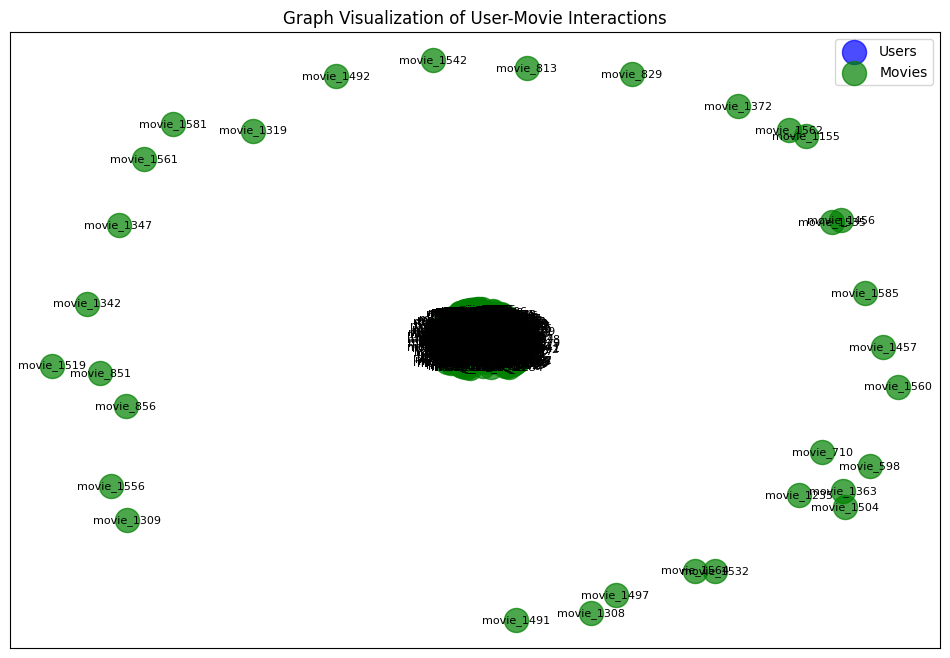

In [11]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Load adjacency matrix and data
adj_matrix = adj_train  # Assuming this is a scipy sparse matrix or similar
u_indices, v_indices = train_u_indices, train_v_indices
labels = train_labels

# Create a NetworkX graph
G = nx.Graph()

# Add nodes and edges
num_users = u_features.shape[0]
num_movies = v_features.shape[0]

# Add user nodes
for user_id in range(num_users):
    G.add_node(f"user_{user_id}", type="user")

# Add movie nodes
for movie_id in range(num_movies):
    G.add_node(f"movie_{movie_id}", type="movie")

# Add edges with labels (if needed)
for u, v, label in zip(u_indices, v_indices, labels):
    G.add_edge(f"user_{u}", f"movie_{v}", label=label)

# Plot the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)  # Spring layout for visualization

# Draw nodes with colors for user/movie types
user_nodes = [node for node, attr in G.nodes(data=True) if attr["type"] == "user"]
movie_nodes = [node for node, attr in G.nodes(data=True) if attr["type"] == "movie"]

nx.draw_networkx_nodes(G, pos, nodelist=user_nodes, node_color="blue", label="Users", alpha=0.7)
nx.draw_networkx_nodes(G, pos, nodelist=movie_nodes, node_color="green", label="Movies", alpha=0.7)

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.5)

# Add labels (optional)
nx.draw_networkx_labels(G, pos, font_size=8)

# Add legend
plt.legend()
plt.title("Graph Visualization of User-Movie Interactions")
plt.show()


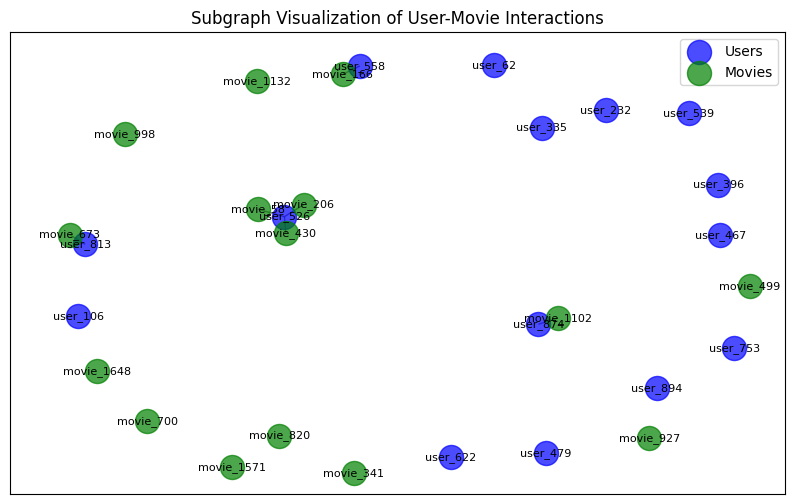

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
from random import sample

# Function to sample a subgraph
def sample_subgraph(G, num_user_nodes=10, num_movie_nodes=10):
    # Randomly sample user and movie nodes
    user_nodes = [node for node, attr in G.nodes(data=True) if attr["type"] == "user"]
    movie_nodes = [node for node, attr in G.nodes(data=True) if attr["type"] == "movie"]

    sampled_user_nodes = sample(user_nodes, min(num_user_nodes, len(user_nodes)))
    sampled_movie_nodes = sample(movie_nodes, min(num_movie_nodes, len(movie_nodes)))

    # Collect edges between sampled nodes
    sampled_nodes = set(sampled_user_nodes + sampled_movie_nodes)
    subgraph = G.subgraph(sampled_nodes)
    return subgraph

# Create a NetworkX graph
G = nx.Graph()

# Add user and movie nodes
num_users = u_features.shape[0]
num_movies = v_features.shape[0]

for user_id in range(num_users):
    G.add_node(f"user_{user_id}", type="user")

for movie_id in range(num_movies):
    G.add_node(f"movie_{movie_id}", type="movie")

# Add edges with labels (if needed)
for u, v, label in zip(train_u_indices, train_v_indices, train_labels):
    G.add_edge(f"user_{u}", f"movie_{v}", label=label)

# Sample a smaller subgraph
subgraph = sample_subgraph(G, num_user_nodes=15, num_movie_nodes=15)

# Plot the subgraph
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(subgraph)  # Spring layout for visualization

# Draw nodes with colors for user/movie types
user_nodes = [node for node, attr in subgraph.nodes(data=True) if attr["type"] == "user"]
movie_nodes = [node for node, attr in subgraph.nodes(data=True) if attr["type"] == "movie"]

nx.draw_networkx_nodes(subgraph, pos, nodelist=user_nodes, node_color="blue", label="Users", alpha=0.7)
nx.draw_networkx_nodes(subgraph, pos, nodelist=movie_nodes, node_color="green", label="Movies", alpha=0.7)

# Draw edges
nx.draw_networkx_edges(subgraph, pos, alpha=0.5)

# Add labels (optional)
nx.draw_networkx_labels(subgraph, pos, font_size=8)

# Add legend
plt.legend()
plt.title("Subgraph Visualization of User-Movie Interactions")
plt.show()


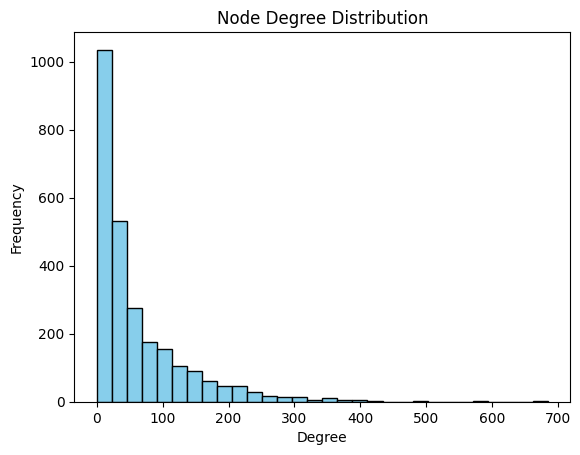

In [13]:
# Plot degree distribution
degrees = [deg for _, deg in G.degree()]
plt.hist(degrees, bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Node Degree Distribution")
plt.show()

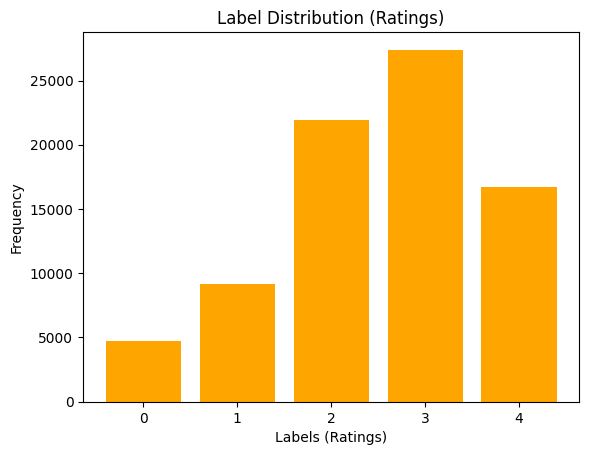

In [14]:
# Ensure train_labels is a PyTorch tensor
train_labels_tensor = torch.tensor(train_labels, device=device)  # Convert to tensor and move to the appropriate device

# Plot label distribution
unique_labels, counts = torch.unique(train_labels_tensor, return_counts=True)
plt.bar(unique_labels.cpu().numpy(), counts.cpu().numpy(), color='orange')
plt.xlabel("Labels (Ratings)")
plt.ylabel("Frequency")
plt.title("Label Distribution (Ratings)")
plt.show()

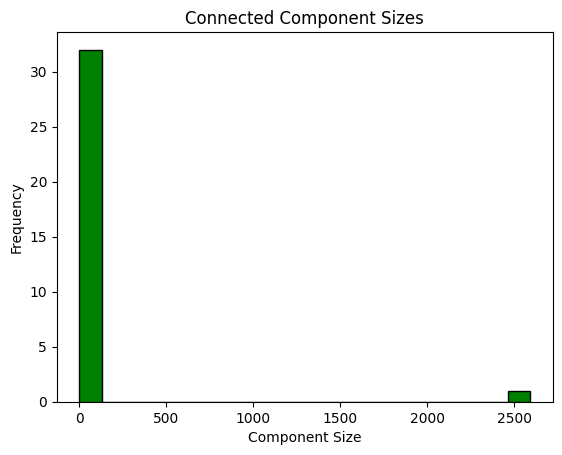

In [15]:
# Plot connected components
connected_components = [len(c) for c in nx.connected_components(G)]
plt.hist(connected_components, bins=20, color='green', edgecolor='black')
plt.xlabel("Component Size")
plt.ylabel("Frequency")
plt.title("Connected Component Sizes")
plt.show()


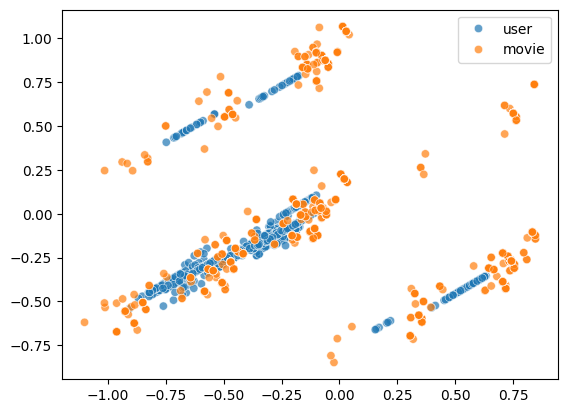

In [16]:
from sklearn.decomposition import PCA
import seaborn as sns

# Combine and reduce dimensions of user and movie features
if u_features is not None and v_features is not None:
    # Convert sparse matrices to dense arrays
    u_features_dense = torch.tensor(u_features.toarray(), device=device)
    v_features_dense = torch.tensor(v_features.toarray(), device=device)

    # Ensure both tensors have the same feature size
    feature_size = min(u_features_dense.size(1), v_features_dense.size(1))
    u_features_dense = u_features_dense[:, :feature_size]  # Truncate to the smaller size
    v_features_dense = v_features_dense[:, :feature_size]  # Truncate to the smaller size

    # Concatenate features
    all_features = torch.cat([u_features_dense, v_features_dense], dim=0).cpu().numpy()

    # Apply PCA
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(all_features)

    sns.scatterplot(
    x=reduced_features[:, 0], y=reduced_features[:, 1],
    hue=["user"] * len(u_features_dense) + ["movie"] * len(v_features_dense),
    alpha=0.7
    )


In [17]:
import pandas as pd
df_ratings = pd.read_csv('ratings.csv')
df_movies = pd.read_csv('movies.csv')
merged = pd.merge(df_ratings, df_movies, on='movieId', how='left')
merged

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,Split (2017),Drama|Horror|Thriller
100832,610,168248,5.0,1493850091,John Wick: Chapter Two (2017),Action|Crime|Thriller
100833,610,168250,5.0,1494273047,Get Out (2017),Horror
100834,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi


<ipython-input-18-9e53e4ca4c9b>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


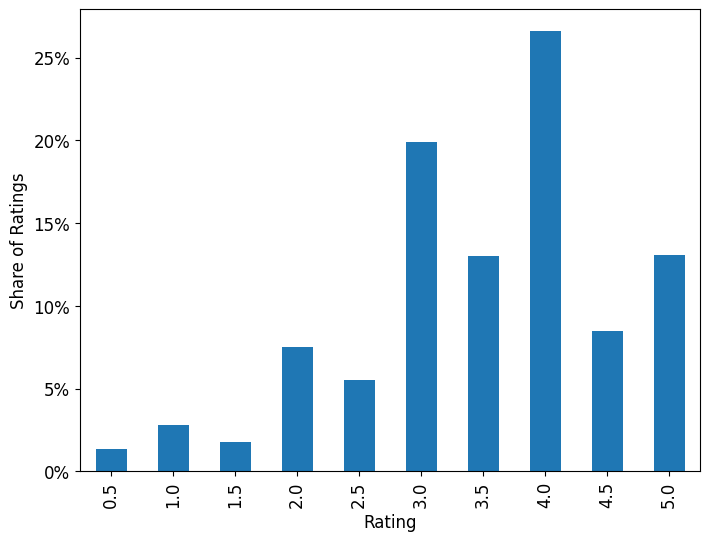

In [18]:
from matplotlib import pyplot as plt

fig = plt.figure()
ax = df_ratings.rating.value_counts(True).sort_index().plot.bar(figsize=(8,6))
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Share of Ratings', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.savefig('Ratings_distribution.png')

In [19]:
R = pd.pivot_table(data=merged, index='userId', columns='title', values='rating')
R

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.5,3.5,NaN,NaN,NaN


Now, we define the IGMC model architecture. It consists of several steps:

1.  Optionally add the graph-level dropout layer. It randomly drops edges from the graph, helping avoid overfitting and making the model more robust.
2. The message passing layer that extracts node information for each node in the subgraph. As proposed in the table, we implement it using R-GCN layer to handle different edge types.
3. Pass it through the tanh non-linearity
4. We stack the outputs of step 2 and 3 at each message passing layer
5. Concatenate the node representations at each layer in the final node representation h.
6. Pull the graph level features g by concatenating target user and item representations.
7. Add a linear layer, ReLU non-linearity, Dropout to avoid overfitting, and final linear layer

All the model parameters were chosen following the IGMC paper.



In [20]:
class IGMC(torch.nn.Module):
    def __init__(self):
        super(IGMC, self).__init__()
        self.rel_graph_convs = torch.nn.ModuleList()
        self.rel_graph_convs.append(RGCNConv(in_channels=4, out_channels=32, num_relations=5, num_bases=4))
        self.rel_graph_convs.append(RGCNConv(in_channels=32, out_channels=32, num_relations=5, num_bases=4))
        self.rel_graph_convs.append(RGCNConv(in_channels=32, out_channels=32, num_relations=5, num_bases=4))
        self.rel_graph_convs.append(RGCNConv(in_channels=32, out_channels=32, num_relations=5, num_bases=4))
        self.linear_layer1 = Linear(256, 128)
        self.linear_layer2 = Linear(128, 1)

    def reset_parameters(self):
        self.linear_layer1.reset_parameters()
        self.linear_layer2.reset_parameters()
        for i in self.rel_graph_convs:
            i.reset_parameters()

    def forward(self, data):
        num_nodes = len(data.x)
        edge_index_dr, edge_type_dr = dropout_adj(data.edge_index, data.edge_type, p=0.2, num_nodes=num_nodes, training=self.training)

        out = data.x
        h = []
        for conv in self.rel_graph_convs:
            out = conv(out, edge_index_dr, edge_type_dr)
            out = torch.tanh(out)
            h.append(out)
        h = torch.cat(h, 1)
        h = [h[data.x[:, 0] == True], h[data.x[:, 1] == True]]
        g = torch.cat(h, 1)
        out = self.linear_layer1(g)
        out = F.relu(out)
        out = F.dropout(out, p=0.5, training=self.training)
        out = self.linear_layer2(out)
        out = out[:,0]
        return out

model = IGMC()

Use a DataLoader to prepare train and test data batches

In [21]:
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=2)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Make sure model is using GPU. Reset the model parameters and define the optimizer. We are using Adam optimizer here

In [22]:
model.to(device)
model.reset_parameters()
optimizer = Adam(model.parameters(), lr=LR, weight_decay=0)

Train the model for number of epochs defined at the beginning.
At each epoch we predict the labels for the batch, find the training MSE loss, do the backpropagation step and update the learnable parameters. Print the training loss at each epoch.

After each LR_DECAY_STEP we decrease the learning rate by a factor of LR_DECAY_VALUE.

In [23]:
import tqdm
for epoch in range(1, EPOCHS+1):
    model.train()
    train_loss_all = 0
    for train_batch in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        train_batch = train_batch.to(device)
        y_pred = model(train_batch)
        y_true = train_batch.y
        train_loss = F.mse_loss(y_pred, y_true)
        train_loss.backward()
        train_loss_all += BATCH_SIZE * float(train_loss)
        optimizer.step()
        torch.cuda.empty_cache()
    train_loss_all = train_loss_all / len(train_loader.dataset)

    print('epoch', epoch,'; train loss', train_loss_all)

    if epoch % LR_DECAY_STEP == 0:
      for param_group in optimizer.param_groups:
          param_group['lr'] = param_group['lr'] / LR_DECAY_VALUE

  0%|          | 0/1600 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)
100%|██████████| 1600/1600 [03:46<00:00,  7.06it/s]


epoch 1 ; train loss 1.306903808452189


100%|██████████| 1600/1600 [03:42<00:00,  7.18it/s]

epoch 2 ; train loss 1.0855030457116663


Assess the performance of the model using the test set by predicting the labels and finding a MSE loss

In [24]:
torch.save(model.state_dict(), "igmc_model_weights.pth")

In [25]:
model.eval()
test_loss = 0
for test_batch in test_loader:
    test_batch = test_batch.to(device)
    with torch.no_grad():
        y_pred = model(test_batch)
    y_true = test_batch.y
    test_loss += F.mse_loss(y_pred, y_true, reduction='sum')
    # torch.cuda.empty_cache()
mse_loss = float(test_loss) / len(test_loader.dataset)

print('test MSE loss', mse_loss)
print('test RMSE loss', math.sqrt(mse_loss))

test MSE loss 0.914544140625
test RMSE loss 0.9563180122872308
